# 2-6. 사이킷런으로 수행하는 타이타닉 생존자 예측

In [40]:
# dataset 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

titanic_df = pd.read_csv('../dataset/titanic/train.csv')
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [41]:
print("데이터 정보")
print(titanic_df.info())

데이터 정보
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


int는 정수, float은 실수, object는 string으로 위와 같이 dtype이 구성됩니다.
- int: PassengerId, Survived, Pclass, SibSp, Parch
- float: Age, Fare
- object: Name, Sex, Ticket, Cabin, Embarked

또한 column은 12개이고 891개의 row로 구성됩니다.

Age, Cabin, Embarked의 각각 714, 204, 889개의 Not Null 값을 가지고 있으므로 각각 177, 608, 2개의 Null(NaN)값을 가지고 있습니다.
사이킷런 머신러닝 알고리즘은 Null 값을 허용하지 않으므로 Null 값을 처리해 주어야 합니다. 보통 fillna()를 이용하여 평균 또는 고정 값으로 변경합니다.

In [42]:
# NaN 데이터 처리
# inplace=True는 기존 데이터 프레임에 변경된 값을 덮어쓰자는 뜻
titanic_df['Age'].fillna(titanic_df['Age'].mean(), inplace=True)    # 평균으로 대체
titanic_df['Cabin'].fillna('N', inplace=True)   # 'N'으로 대체
titanic_df['Embarked'].fillna('N', inplace=True)    # 'N'으로 대체
print("데이터 세트의 Null 개수: ", titanic_df.isnull().sum())

데이터 세트의 Null 개수:  PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64


In [43]:
print("Sex 값 분포: \n", titanic_df['Sex'].value_counts())
print("\n Cabin 값 분포: \n", titanic_df['Cabin'].value_counts())
print("\n Embarked 값 분포: \n", titanic_df['Embarked'].value_counts())

Sex 값 분포: 
 Sex
male      577
female    314
Name: count, dtype: int64

 Cabin 값 분포: 
 Cabin
N              687
C23 C25 C27      4
G6               4
B96 B98          4
C22 C26          3
              ... 
E34              1
C7               1
C54              1
E36              1
C148             1
Name: count, Length: 148, dtype: int64

 Embarked 값 분포: 
 Embarked
S    644
C    168
Q     77
N      2
Name: count, dtype: int64


In [44]:
# Cabin 속성의 경우 선실 등급을 나타내는 첫 번째 알파벳이 중요
# 따라서 앞 문자만 추출
titanic_df['Cabin'] = titanic_df['Cabin'].str[:1]
titanic_df['Cabin'].head()


0    N
1    C
2    N
3    C
4    N
Name: Cabin, dtype: object

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

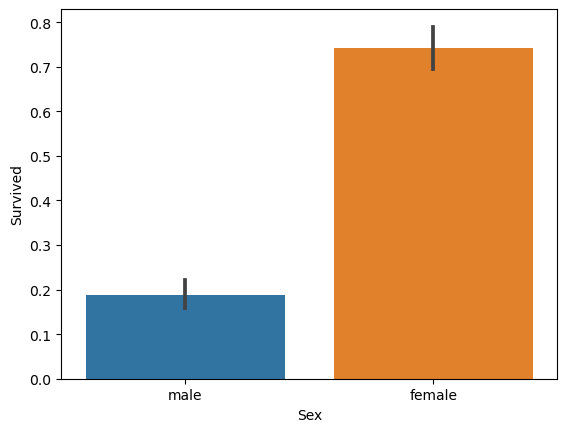

In [45]:
# 성별이 생존 확률에 어떤 영향을 미쳤는지, 성별에 따른 생존자 수 비교
sns.barplot(x='Sex', y='Survived', data=titanic_df) # 시각화
titanic_df.groupby(['Sex', 'Survived'])['Survived'].count()
# groupby: 데이터를 그룹별로 분할하여 독립된 그룹에 대하여 별도로 데이터를 처리(혹은 적용)하거나 그룹별 통계량을 확인

Pclass  Sex   
1       female     94
        male      122
2       female     76
        male      108
3       female    144
        male      347
Name: Survived, dtype: int64

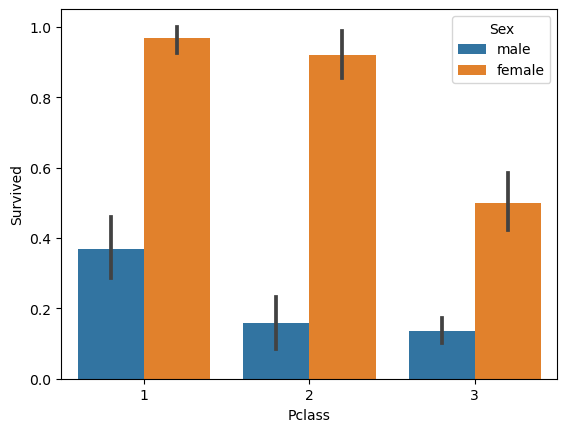

In [46]:
# 객실 등급별 확인
# hue를 적용하여 카테고리 별로 확인 가능
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=titanic_df)
titanic_df.groupby(['Pclass','Sex'])['Survived'].count()


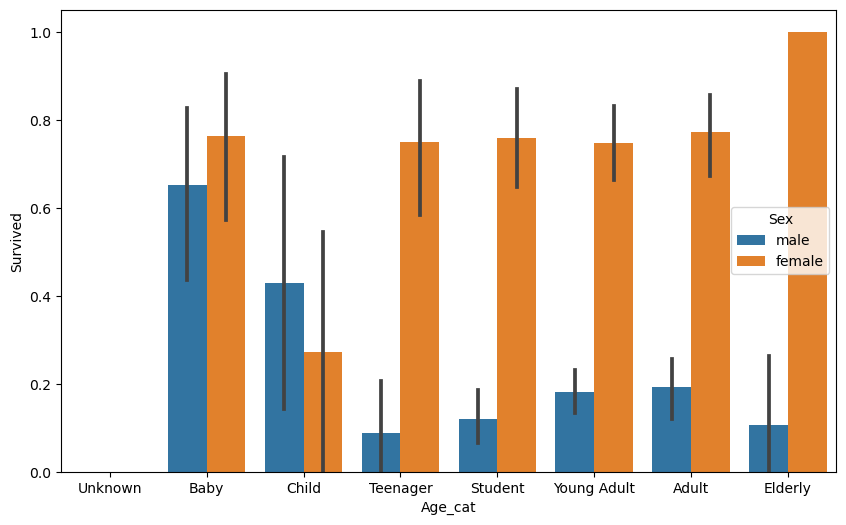

In [47]:
# 입력 age에 따라 구분값을 반환하는 함수 설정. DataFrame의 apply lambda식에 사용. 
def get_category(age):
    cat = ''
    if age <= -1: cat = 'Unknown'
    elif age <= 5: cat = 'Baby'
    elif age <= 12: cat = 'Child'
    elif age <= 18: cat = 'Teenager'
    elif age <= 25: cat = 'Student'
    elif age <= 35: cat = 'Young Adult'
    elif age <= 60: cat = 'Adult'
    else : cat = 'Elderly'
    
    return cat

# 막대그래프의 크기 figure를 더 크게 설정 
plt.figure(figsize=(10,6))

#X축의 값을 순차적으로 표시하기 위한 설정 
group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Elderly']

titanic_df['Age_cat'] = titanic_df['Age'].apply(lambda x : get_category(x)) # lambda 함수 이용
sns.barplot(x='Age_cat', y='Survived', hue='Sex', data=titanic_df, order=group_names) # 시각화
titanic_df.drop('Age_cat', axis=1, inplace=True) # 시각화 이후 필요 없으므로 삭제

In [48]:
# 문자형 카테고리 피처 숫자로 변환
from sklearn import preprocessing

def encode_feature(dataDF):
    features = ['Cabin', 'Sex', 'Embarked'] # 숫자로 바꿀 문자형 feature들

    for feature in features:
        le = preprocessing.LabelEncoder()   # 레이블 인코딩 적용
        le = le.fit(dataDF[feature])
        dataDF[feature] = le.transform(dataDF[feature])
    
    return dataDF

titanic_df = encode_feature(titanic_df)
titanic_df.head()
# Sex, Cabin, Embarked가 숫자형으로 바뀐 것을 확인 할 수 있다.


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,7,3
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,2,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,7,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,2,3
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,7,3


In [49]:
# 데이터의 전처리를 전체적으로 호출하는 함수
from sklearn.preprocessing import LabelEncoder

# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

# 머신러닝 알고리즘에 불필요한 피처 제거
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df


# 레이블 인코딩 수행.
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df


# 앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [52]:
titanic_df = pd.read_csv('../dataset/titanic/train.csv')
y_titanic_df = titanic_df['Survived']
x_titanic_df = titanic_df.drop('Survived', axis=1)

x_titanic_df = transform_features(x_titanic_df)

In [53]:
# 데이터 분리
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_titanic_df, y_titanic_df, test_size=0.2)

In [57]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

dt_clf = DecisionTreeClassifier()
rf_clf = RandomForestClassifier()
lr_clf = LogisticRegression(max_iter=5000) # max_iter 설정시 오류x

# DecisionTree 학습/예측/평가
dt_clf.fit(x_train, y_train)
dt_pred = dt_clf.predict(x_test)
print("DecisionTreeClassifier 정확도: {0:.4f}".format(accuracy_score(y_test, dt_pred)))

# RandomForest 학습/예측/평가
rf_clf.fit(x_train, y_train)
rf_pred = rf_clf.predict(x_test)
print("RandomForest 정확도: {0:.4f}".format(accuracy_score(y_test, rf_pred)))

# LogisticRegression 학습/예측/평가
lr_clf.fit(x_train, y_train)
lr_pred = lr_clf.predict(x_test)
print("LogisticRegression 정확도: {0:.4f}".format(accuracy_score(y_test, lr_pred)))

DecisionTreeClassifier 정확도: 0.7654
RandomForest 정확도: 0.8045
LogisticRegression 정확도: 0.7989


In [58]:
from sklearn.model_selection import KFold

def exec_kfold(clf, folds=5):
    kfold = KFold(n_splits=folds)
    scores = [] # 예측 결과 저장

    # KFold
    for iter_num, (train_index, test_index) in enumerate(kfold.split(x_titanic_df)):
        x_train, x_test = x_titanic_df.values[train_index], x_titanic_df.values[test_index]
        y_train, y_test = y_titanic_df.values[train_index], y_titanic_df.values[test_index]

        # classifier 학습/예측/정확도 계산

        clf.fit(x_train, y_train)
        predictions = clf.predict(x_test)
        accuracy = accuracy_score(y_test, predictions)
        scores.append(accuracy) # 정확도 저장
        print("교차 검증 {0} 정확도: {1:.4f}".format(iter_num, accuracy))

    
    mean_score = np.mean(scores) # 평균 계산
    print("평균 정확도: {0:.4f}".format(mean_score))

exec_kfold(dt_clf, folds=5)

교차 검증 0 정확도: 0.7542
교차 검증 1 정확도: 0.7584
교차 검증 2 정확도: 0.7978
교차 검증 3 정확도: 0.7753
교차 검증 4 정확도: 0.8202
평균 정확도: 0.7812


In [60]:
# cross_val_score 이용
# cross_val_score은 StratifiedKFold를 이용

from sklearn.model_selection import cross_val_score

scores = cross_val_score(dt_clf, x_titanic_df, y_titanic_df, cv=5)
for iter_num, accuracy in enumerate(scores):
    print("교차 검증 {0} 정확도: {1:.4f}".format(iter_num, accuracy))

print("평균 정확도: {0:.4f}".format(np.mean(scores)))

교차 검증 0 정확도: 0.7374
교차 검증 1 정확도: 0.7640
교차 검증 2 정확도: 0.8090
교차 검증 3 정확도: 0.7809
교차 검증 4 정확도: 0.8427
평균 정확도: 0.7868


In [61]:
# GridSearchCV 이용
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':[2, 3, 5, 10],
              'min_samples_split':[2, 3, 5],
              'min_samples_leaf':[1, 5, 8]}

grid_dclf = GridSearchCV(dt_clf, param_grid=parameters, scoring='accuracy', cv=5)
grid_dclf.fit(x_train, y_train)

print("최적의 하이퍼 파라미터: ", grid_dclf.best_params_)
print("최고 정확도: {0:.4f}".format(grid_dclf.best_score_))

best_dclf = grid_dclf.best_estimator_
predictions = best_dclf.predict(x_test)
accuracy = accuracy_score(y_test, predictions)

print("테스트 세트 정확도: {0:.4f}".format(accuracy))

최적의 하이퍼 파라미터:  {'max_depth': 3, 'min_samples_leaf': 8, 'min_samples_split': 2}
최고 정확도: 0.8062
테스트 세트 정확도: 0.8101
